<a href="https://colab.research.google.com/github/sshakya03/Israel-Palestine-Opinion-Analysis/blob/main/Final_Project_105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Israel/Palestine Text Mining : CS105 Final Project**
Risa Onishi (3rd year data science)

Sazen Shakya (3rd year computer science)

Haru Sakamoto (3rd year data science)

Ashna Pradhan (3rd year computer science)

#**1. Project Description**

For our final project, we analyzed the public opinion on the Israel-Palestine War. Our goal was to gain a deeper understanding of the public’s opinion regarding the war and analyze what factors could have impacted the controversy and interactions in reddit comments. The basis of our analysis came from a dataset consisting of Reddit comments that were made on posts about the Israel-Palestine War. The dataset consists of data from 9/2/2023 (prior to the major events of 2023), and is updated on a daily basis to this day. The data that we used for this project consisted of the comment text, upvotes, downvotes, time created, subreddit, and controversiality. As the dataset is updated every day, extensive cleaning is required to use the data for analysis.


#**2. Data Collection and Data Cleaning**
**Dataset:** [Daily Public Opinion on Israel-Palestine War by Asaniczka
](https://www.kaggle.com/datasets/asaniczka/reddit-on-israel-palestine-daily-updated?resource=download
)

## a. Installations

In [ ]:
!pip install kaggle
!pip install scikit-learn pandas
!pip install langdetect
!pip install -q transformers

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import ast
from langdetect import detect
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from collections import Counter
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import warnings


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download asaniczka/reddit-on-israel-palestine-daily-updated
! unzip /content/reddit-on-israel-palestine-daily-updated.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/asaniczka/reddit-on-israel-palestine-daily-updated
License(s): ODC Attribution License (ODC-By)
reddit-on-israel-palestine-daily-updated.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/reddit-on-israel-palestine-daily-updated.zip
replace legacy/pse_isr_reddit_comments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
original_df = pd.read_csv('reddit_opinion_PSE_ISR.csv')

In [ ]:
df = original_df.sample(n=10000, random_state=24)
df = df[['self_text', 'subreddit', 'created_time', 'controversiality', 'ups', 'downs']]
df.to_csv('sampled_data.csv', index=False)

In [ ]:
df = pd.read_csv('sampled_data.csv')

## b. Text Preprocessing

###i. Removing links and non-English

In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

def has_link(text):
    link_pattern = re.compile(r'http\S+|www\S+')
    return bool(link_pattern.search(text))

df['language'] = df['self_text'].apply(detect_language)
df = df[df['language'] == 'en']

mask = df['self_text'].apply(has_link)
df = df[~mask]

df = df.drop(columns=['language'])

Data Cleaning: Before starting any analysis on the dataset, we realized that there were many comments that were either in another language or had links. So we first cleaned the data by removing any comments that were not in English or contained a link (starting with “http” or “www”). We also got rid of any columns that we were not going to use, leaving us with the columns, self_text, subreddit, upvotes, downvotes, and controversiality.


###ii.  Tokenizations

In [ ]:
custom_stopwords = {"n't", "ve", "ca", "don", "d", "re", "m", "https", "gt", "s", "t", "u", " ",
                    'yes', 'even', 'going', 'got', 'lot', 'probably', 'really', 'make', 'done', 'made',
                    'many', 'give', 'done', 'two', 'sure', 'thing', 'things', "'s", "'m",
                    'actually', 'would', 'like', 'also', 'though', 'may', 'go', 'literally', 'already',
                    'much', 'could', 'something', 'back', 'let', 'know', 'maybe', 'think', 'saying', 'use',
                    'yeah', 'keep', 'since', 'get', 'one', 'getting', 'lol', 'always', 'new', 'چپیه',
                    'another', 'around', 'either', 'makes', 'try', 'see', 'trying', 'still', 'find', 'anyone',
                    ',', '.', '"', '“', '”' ,'\'', '’', '(', ')', ':', '&', ';', 'put', 'part'}
nltk_stopwords = set(stopwords.words('english'))
all_stopwords = custom_stopwords.union(nltk_stopwords)

def tokenize_text(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if len(word) <= 20]
        filtered_text = ' '.join(filtered_words)
        tokens = word_tokenize(filtered_text)
        filtered_tokens = [
            token for token in tokens
            if token.lower() not in all_stopwords
        ]
        return filtered_tokens
    else:
        return ['']

df['self_text_tokens'] = df['self_text'].apply(tokenize_text)
all_tokens = " ".join([" ".join(tokens) for tokens in df['self_text_tokens']])

In [ ]:
df.to_csv('sampled_data.csv', index=False)

We used a set of stop words from the NLTK library as well as defined our own custom stopwords to create one large set of stopwords. We then tokenized the text and removed any stopwords.

# **3. Exploratory Data Analysis**

## a. Word Cloud



We can begin our analysis by creating a word cloud of the dataset's top terms. The word cloud will show the most frequently occurring words in the dataset, with the size of each word reflecting its frequency of appearance. A word cloud can help us identify the most significant discussions of our topic and thus help drive our  investigation.

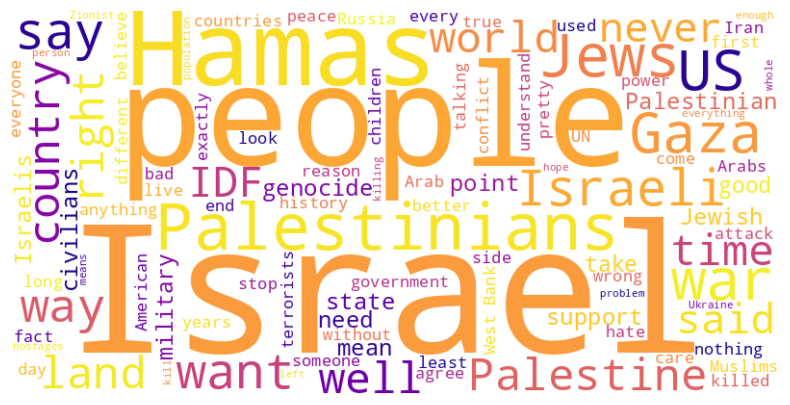

In [ ]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='plasma',
    normalize_plurals=False,
    stopwords=all_stopwords,
    max_words=100
).generate(all_tokens)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As depicted in our word cloud, terms such as "Israel", "people", and "Hamas" are the most frequently occurring terms of our dataset. The frequent appearance of terms like "war," "support," "genocide," and "Gaza" suggest a focus on the violence and humanitarian aspects of the conflict. Additionally, the inclusion of terms such as "right," "state," "history," and "military" point to discussions around national sovereignty, political rights, and military actions.





#b. Bar Graphs

We will be using bar graphs to compare subreddits and see if there are any key terms or factors that contribute to a comment being controversial.

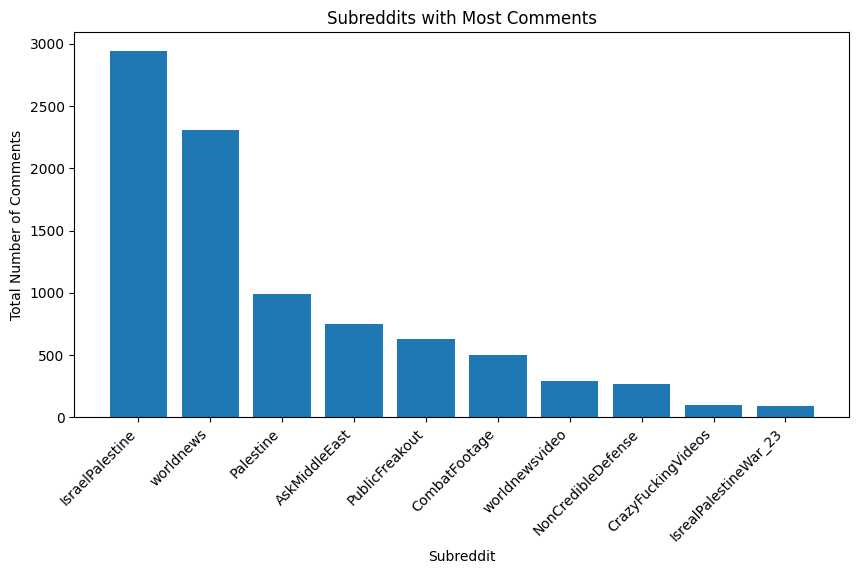

In [ ]:
subreddit_comments = df['subreddit'].value_counts()
subreddit_comments = subreddit_comments.sort_values(ascending=False)

top_subreddits = subreddit_comments.head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_subreddits.index, top_subreddits.values)
plt.title('Subreddits with Most Comments')
plt.xlabel('Subreddit')
plt.ylabel('Total Number of Comments')
plt.xticks(rotation=45, ha='right')
plt.show()

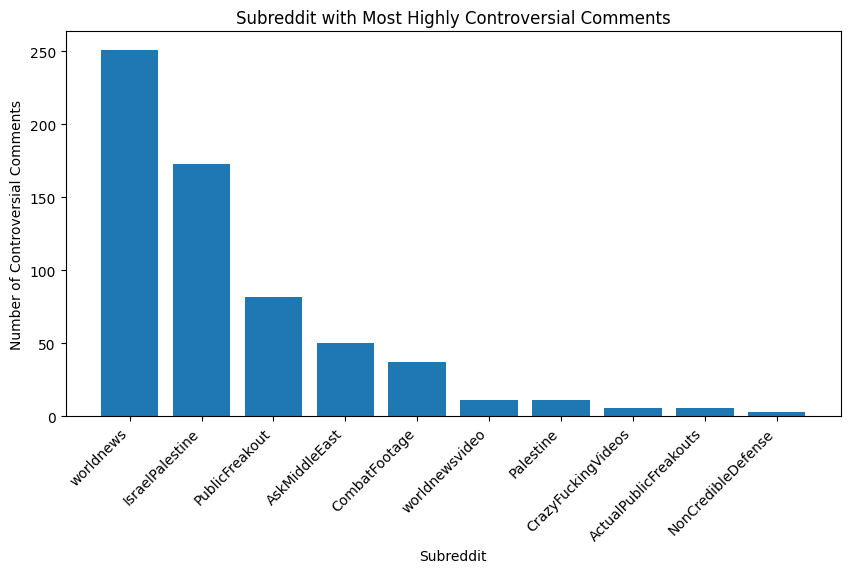

In [ ]:
controversial_comments = df[(df['controversiality'] >= 0.98) & (df['controversiality'] <= 1)]
subreddit_counts = controversial_comments['subreddit'].value_counts().head(10)
top_subreddit = subreddit_counts.idxmax()
max_count = subreddit_counts.max()

plt.figure(figsize=(10, 5))
plt.bar(subreddit_counts.index, subreddit_counts.values)
plt.title('Subreddit with Most Highly Controversial Comments')
plt.xlabel('Subreddit')
plt.ylabel('Number of Controversial Comments')
plt.xticks(rotation=45, ha='right')
plt.show()

The first chart shows us the top 10 subreddits with the most comments. The second chart shows us the top 10 subreddits with the most controversial comments. The way we measured whether or not a comment was controversial was by gathering comments that had a controversiality rating of 0.98-1.00, which is a rating that is determined by the amount of likes and interactions a comment has. The overall comments takes the data from all 10000 datapoints, so has a high frequency. But since the number for comments that are controversial goes down drastically, the overall count also go down as well. As we can see, the subreddit with the most overall comments is IsrealPalestine subreddit, but the subreddit with the most controversial comments is worldnews. Although there are more comments in the IsrealPalestine subreddit, there is more controversy in the worldnew subreddit.

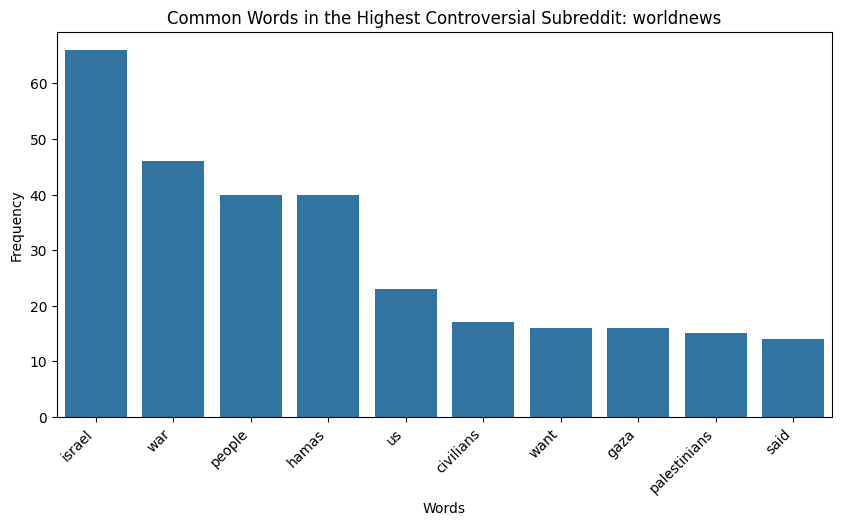

In [ ]:
highest_subreddit = controversial_comments['subreddit'].value_counts().idxmax()

filtered_posts = controversial_comments[controversial_comments['subreddit'] == highest_subreddit]
all_text = ' '.join(filtered_posts['self_text'].astype(str).tolist())

tokens = word_tokenize(all_text)
filtered_tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in all_stopwords]
word_counts = Counter(filtered_tokens)
top_words = word_counts.most_common(10)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=words, y=counts)
plt.title(f'Common Words in the Highest Controversial Subreddit: {highest_subreddit}')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

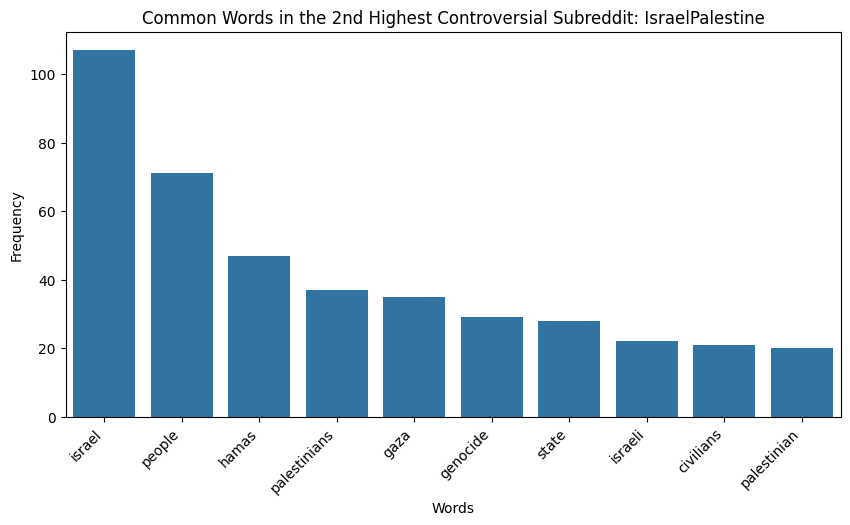

In [ ]:
second_highest_subreddit = controversial_comments['subreddit'].value_counts().index[1]
filtered_posts = controversial_comments[controversial_comments['subreddit'] == second_highest_subreddit]
all_text = ' '.join(filtered_posts['self_text'].astype(str).tolist())

tokens = word_tokenize(all_text)
filtered_tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in all_stopwords]
word_counts = Counter(filtered_tokens)
top_words = word_counts.most_common(10)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=words, y=counts)
plt.title(f'Common Words in the 2nd Highest Controversial Subreddit: {second_highest_subreddit}')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

The following two graphs show the frequency of the most used words in the top 2 controversial subreddits, which are the 2 subreddits that had the most controversial comments. In the worldnews subreddit we see words that cover a broader scope, such as "wars", "civilians", "countries" and, "country". On the other hand, in the Israel-Palestine subreddit, we can see that there are more words that focus more on the conflict, such as "palestinians","palestinian" "jews", and "israeli". We can also see that even though the total number of controversial comments is less for the IsraelPalestine subreddit, there is a way higher frequency of the word "Israel". From this, we can infer that comments in a subreddit that cover a broader scope and global events tend to cause more controversy than comments that focus on specific events.

#c. Time Series

Continuing with the controversiality feature, we can track the occurrence of controversial comments and compare its trends to real-world events. We will use a proportion of controversial posts rather than a count to obtain a more precise depiction of trends.

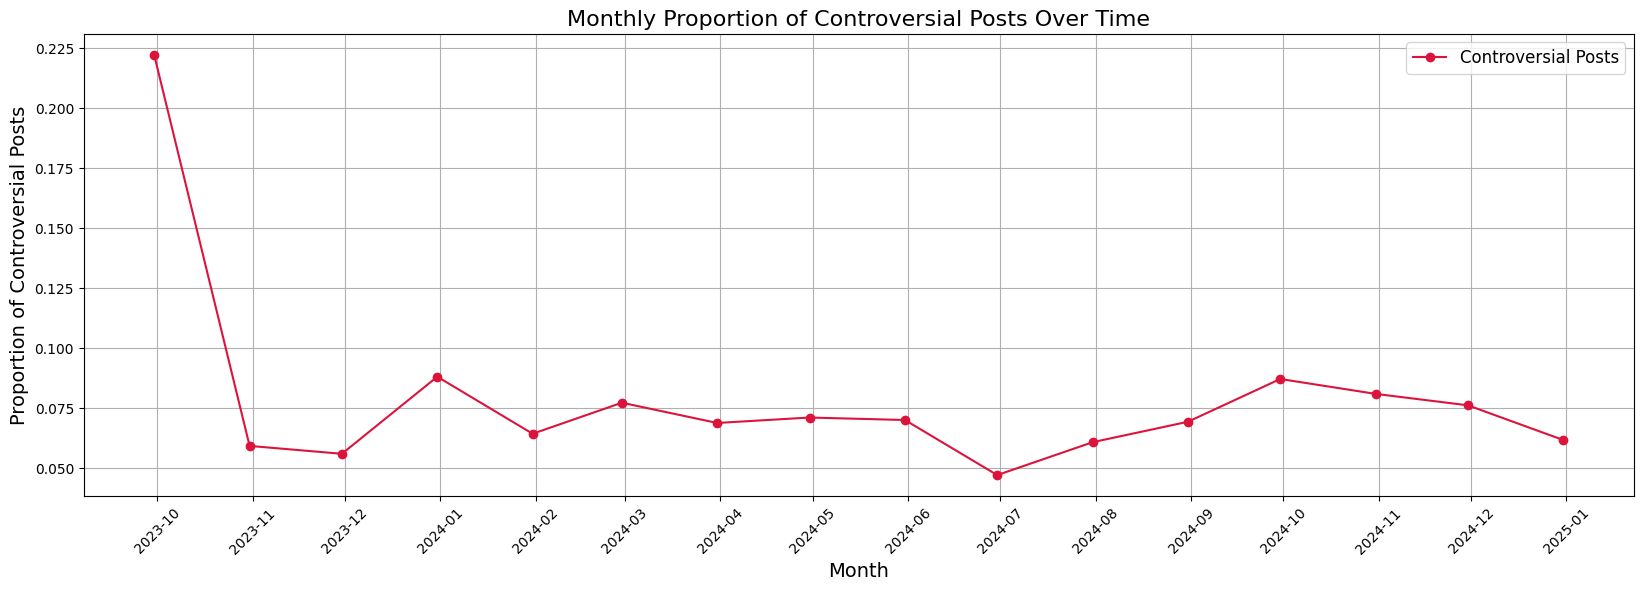

In [ ]:
import matplotlib.dates as mdates

df = pd.read_csv('sampled_data.csv')

df['Date'] = pd.to_datetime(df['created_time'])
controversial_posts = df[(df['controversiality'] >= 0.98) & (df['controversiality'] <= 1)]

monthly_totals = df.resample('M', on='Date').size().reset_index(name='Total_Posts')
monthly_controversial_counts = controversial_posts.resample('M', on='Date').size().reset_index(name='Controversial_Posts')

monthly_data = pd.merge(monthly_totals, monthly_controversial_counts, on='Date', how='left')
monthly_data['Proportion_Controversial'] = monthly_data['Controversial_Posts'] / monthly_data['Total_Posts']

plt.figure(figsize=(20, 6))
plt.plot(monthly_controversial_counts['Date'],monthly_data['Proportion_Controversial'],
         marker='o', linestyle='-', color='crimson', label='Controversial Posts')

plt.title('Monthly Proportion of Controversial Posts Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Proportion of Controversial Posts', fontsize=14)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize=12)

plt.show()

A time series visualization was the chosen method to display such data as it can help us identify key trends over time and if such trends can relate to the major events of the Israel-Palestine War. If such correlations can be inferred, it may also be possible to predict future public opinion trends depending on real-time world events.

This graph shows the proportion of controversial comments compared to all comments each month from October 2023 to the present. The graph begins with a high proportion of controversial posts, likely due to the major event of the Israel-Palestine War that began on October 7, 2023, when the militant group Hamas launched a large-scale attack on Israel. Another noticeable spike appears in the data between December 2023 and January 2024. This may be related to South Africa initiating legal proceedings against Israel at the International Court of Justice on December 29, 2023, accusing Israel of committing genocide against Palestinians. Then, we can observe a decline in the proportion of controversial comments in June 2024. This decline may be attributed to the various global elections that took place around this time, which likely shifted worldwide attention away from the Israel-Palestine conflict. Finally, we observe an increase in the proportion of controversial comments as we approach October 2024 due to the assassination of Hamas leader Yahya Sinwar and the 1-year mark of the October 7 event. This uptick may reflect the continued global attention on the Israel-Palestine conflict. However, we also see a gradual decline in controversial posts around the time of the U.S. presidential elections, likely due to the shift in global focus toward the elections and related political events.

##d. TF-IDF

In [ ]:
document = [all_tokens]
tfidf_vectorizer = TfidfVectorizer(stop_words=list(all_stopwords))
tfidf_matrix = tfidf_vectorizer.fit_transform(document)
terms = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray()[0]
tfidf_df = pd.DataFrame({'term': terms, 'tfidf_score': scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)
tfidf_df.reset_index(drop=True, inplace=True)

In [ ]:
df['joined_text'] = df['self_text_tokens'].apply(lambda tokens: " ".join(tokens))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['joined_text'])
terms = vectorizer.get_feature_names_out()
results = []
for idx, row in enumerate(tfidf_matrix.toarray()):
    comment_scores = sorted(zip(terms, row), key=lambda x: x[1], reverse=True)
    results.append(pd.DataFrame(comment_scores, columns=['term', 'tfidf_score']))

for i, df in enumerate(results):
    print(f"\nComment {i + 1} TF-IDF Scores:")
    print(df.head())


Streaming output truncated to the last 5000 lines.

Comment 8376 TF-IDF Scores:
       term  tfidf_score
0       erm     0.603151
1      mark     0.500013
2  humanity     0.399490
3     using     0.329087
4     world     0.256928

Comment 8377 TF-IDF Scores:
           term  tfidf_score
0  municipality     0.440772
1         hired     0.408311
2        subway     0.408311
3           dig     0.370334
4          aviv     0.337873

Comment 8378 TF-IDF Scores:
     term  tfidf_score
0  charge          1.0
1      00          0.0
2     000          0.0
3    0000          0.0
4    0006          0.0

Comment 8379 TF-IDF Scores:
       term  tfidf_score
0  hopefuly     0.529402
1    rafidi     0.529402
2    wiping     0.490414
3      nice     0.344018
4     every     0.241694

Comment 8380 TF-IDF Scores:
       term  tfidf_score
0       tax     0.376968
1   dollars     0.361936
2  american     0.274881
3   handing     0.227778
4   session     0.227778

Comment 8381 TF-IDF Scores:
       term  

TF-IDF evaluates a term's significance in a document relative to a corpus. For this project, TF-IDF is applied to Reddit comments using tokenization, stopword removal, and scikit-learn's TfidfVectorizer. The top five terms for each comment are ranked by their TF-IDF scores to identify the most significant words of each comment. This analysis contributes to the study by providing insight into the unique views of each comment and how they compare to the comprehensive discussion regarding the topic. We will later be utilizing these TF-IDF scores for K-Means Clustering.

#**4. Methods, Techniques, and Algorithms**

##**a. Sentiment Analysis**
Sentiment analysis is a text analysis process pertaining to the connotation, or emotion, of a text. Here, we want to focus on the classification of each comment as negative, neutral, or positive, with values signifying the possibility of each. We will perform this via pre-trained sentiment analysis models on HuggingFace.

### Model 1:
[DistilBERT Base Uncased Sentiment Reddit Model](https://huggingface.co/mwkby/distilbert-base-uncased-sentiment-reddit-crypto)

https://huggingface.co/blog/sentiment-analysis-python

In [ ]:
model_name='mwkby/distilbert-base-uncased-sentiment-reddit-crypto'
sentiment_task = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

def get_sentiment(tokens, chunk_size=256):
    if not tokens:
        return "NEUTRAL"

    sentiments = []
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i + chunk_size]
        text = " ".join(chunk)
        sentiment = sentiment_task(text)[0]['label']
        sentiments.append(sentiment)

    return max(set(sentiments), key=sentiments.count)

df['sentiment'] = df['self_text_tokens'].apply(get_sentiment)

The first model we attempted to implement was the DistilBERT Base Uncased Sentiment Reddit Model from HuggingFace. We thought this model would fit our data well due to the fact that it is trained on Reddit data. However, the model ended up not producing very accurate results, which we could tell just from looking at a sample of 10000 posts. For instance, it flagged “They are both beautiful with great food and good weather” as "negative" despite its overwhelmingly positive sentiment. We judge that this discrepacncy was born from the fact that we used our own tokenized column with our custom stopwords removed, which may have removed too much context and possibly terms important for analysis. Learning from this experience, we implemented a different model and different tokenization approach, which will be discussed in the next section.

### Model 2:
[Twitter roBERTa Base Sentiment Model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def get_sentiment_scores(text, chunk_size=512):
    sentiments = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i + chunk_size]
        encoded_input = tokenizer(chunk, return_tensors='pt', padding=True)
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        sentiments.append(scores)

    average_sentiment = np.mean(sentiments, axis=0)  # Average the sentiment scores of each category for that comment
    return average_sentiment

df['sentiment_scores'] = df['self_text'].apply(get_sentiment_scores)
df['negative'] = [score[0] for score in df['sentiment_scores']]
df['neutral'] = [score[1] for score in df['sentiment_scores']]
df['positive'] = [score[2] for score in df['sentiment_scores']]
df

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


self_text        subreddit  \
0     I see where you’re coming from, but Turkey rec...  IsraelPalestine   
1                               Disgusting freaks ! WTF        Palestine   
2     I hate pretty much everything about what happe...   PublicFreakout   
3     A few hundred drones was Iran walking the line...        worldnews   
4     She died peacefully of natural causes after a ...        Palestine   
...                                                 ...              ...   
8995  The truth? What truth is that, that justifies ...  IsraelPalestine   
8996                           You voted for him, AGAIN        worldnews   
8997  The UNRWA has long been discussed on old forum...        worldnews   
8998         GWB walked into walls and wasn't even old.        Palestine   
8999  You realize Canada and the US have their own m...        worldnews   

             created_time  controversiality  ups  downs  \
0     2023-11-16 01:17:33                 0    2      0   
1     2024-08-10 13:42:55                 0    2      0   
2     2024-10-01 21:55:51                 0    5      0   
3     2024-04-14 15:54:16                 0   64      0   
4     2024-09-06 21:44:29                 0   10      0   
...                   ...               ...  ...    ...   
8995  2023-12-07 18:45:35                 0    1      0   
8996  2023-12-02 22:47:48                 0    5      0   
8997  2024-03-20 02:20:44                 0   40      0   
8998  2024-04-29 02:11:31                 0    4      0   
8999  2024-10-06 02:11:28                 0    3      0   

     user_account_created_time  \
0          2023-06-17 03:40:12   
1          2022-01-11 18:21:59   
2          2011-12-28 06:22:55   
3          2020-09-06 19:05:11   
4          2013-10-24 02:21:13   
...                        ...   
8995       2022-11-16 04:40:47   
8996       2013-10-09 17:19:04   
8997       2022-05-13 23:11:22   
8998       2023-09-01 04:32:44   
8999       2021-05-28 09:29:25   

                                         post_self_text  \
0     People talk about Israelis being disgraceful, ...   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
8995  Edit: myself isn't a man.\n\nI am Israeli left...   
8996                                                NaN   
8997                                                NaN   
8998                                                NaN   
8999                                                NaN   

                                             post_title    post_created_time  \
0     Double Standards on the International Stage an...  2023-11-15 12:05:29   
1     The IDF soldier from Unit 100 who raped* &amp;...  2024-08-09 18:01:51   
2     First hand account from Impact Plastics employ...  2024-10-01 15:11:42   
3     'You got a win. Take the win': Joe Biden tells...  2024-04-14 13:43:48   
4     American activist shot dead in occupied West Bank  2024-09-06 13:36:38   
...                                                 ...                  ...   
8995                                           Hopeless  2023-12-07 05:22:05   
8996  'Hamas is a reality of Palestine': Turkey's Er...  2023-12-02 14:09:20   
8997  Hamas chief Ismail Haniyeh was an UNRWA teache...  2024-03-19 22:27:34   
8998                    Why Joe Biden Won’t Stop Israel  2024-04-28 17:57:28   
8999  Iranian oil tankers flee crude loading site am...  2024-10-04 23:00:38   

                                       self_text_tokens sentiment  \
0     ['’', 'coming', ',', 'Turkey', 'receives', 'en...  negative   
1                  ['Disgusting', 'freaks', '!', 'WTF']  negative   
2     ['hate', 'pretty', 'everything', 'happened', '...  negative   
3     ['hundred', 'drones', 'Iran', 'walking', 'line...  negative   


In [ ]:
df = pd.read_csv('final_sentiment.csv')
def get_sentiment_label(row):
    scores = [row['negative'], row['neutral'], row['positive']]
    labels = ['negative', 'neutral', 'positive']
    max_index = np.argmax(scores)
    return labels[max_index]

df['sentiment_model2'] = df.apply(get_sentiment_label, axis=1)

The model implementation we decided to use for the rest of our analysis is also from HuggingFace, the Twitter roBERTa Base Sentiment Model. Although this model was trained on Twitter data, we found it well-suited for analyzing Reddit comments as well, since both are similarly opinionated social media platforms with short text (Comments/Tweets). Using the model, we derive the sentiment scores of each post with three metrics, negative, neutral, and positive. Each of the three is assigned a value from 0-1, indicating the probability of that sentiment. The 3 values add up to a total of 1. We use the `get_sentiment_label` function to assign each comment negative, neutral, or positive based on the highest value recorded among the three categories.

*Due to device limitations (lack of GPU) and Colab plan limitations, we had to restrict the size of our database for methods to run. We utilized a random sample of 10k comments, which takes approximately an hour to run.

### Visualizations:

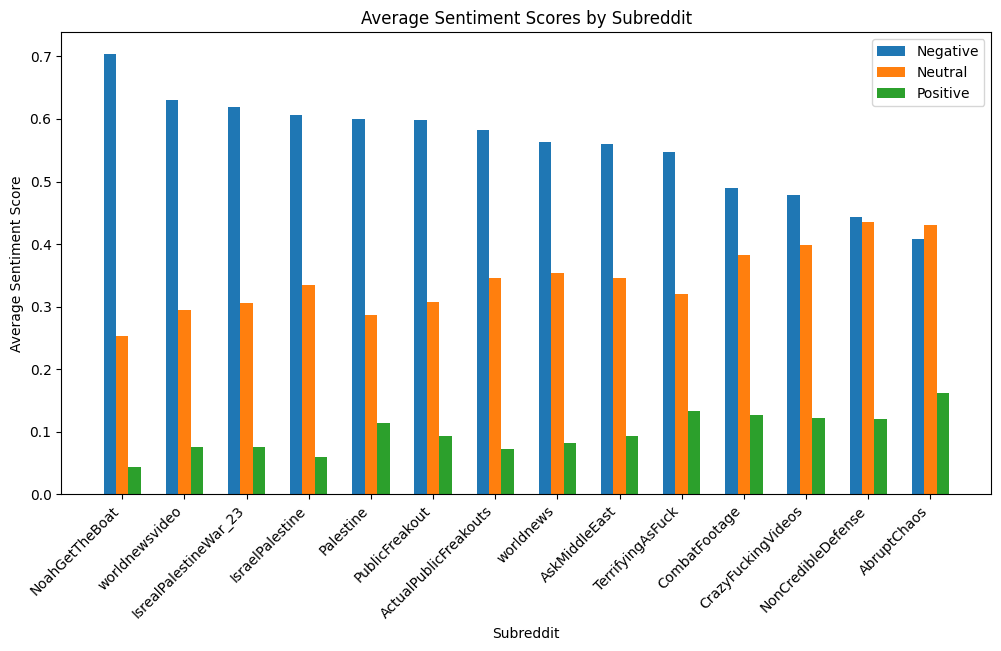

In [ ]:
subreddit_sentiments = df.groupby('subreddit')[['negative', 'neutral', 'positive']].mean()
subreddit_sentiments = subreddit_sentiments.sort_values(by='negative', ascending=False)

subreddits = subreddit_sentiments.index
negative_scores = subreddit_sentiments['negative']
neutral_scores = subreddit_sentiments['neutral']
positive_scores = subreddit_sentiments['positive']

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2

ax.bar(x_pos - bar_width, negative_scores, width=bar_width, label='Negative')
ax.bar(x_pos, neutral_scores, width=bar_width, label='Neutral')
ax.bar(x_pos + bar_width, positive_scores, width=bar_width, label='Positive')

ax.set_xticks(x_pos)
ax.set_xticklabels(subreddits, rotation=45, ha='right')
ax.set_xlabel('Subreddit')
ax.set_ylabel('Average Sentiment Score')
ax.set_title('Average Sentiment Scores by Subreddit')
ax.legend()

This bar graph displays the average sentiment scores of each subreddit. There exists only one subreddit that does not have negative sentiment with a leading score, suggesting a majority of negative sentiment across all subreddits. The farthest left subreddit, r/NoahGetTheBoat, is focused around "horrible acts from humanity," which makes sense as to why it is ranked highest in negative sentiment.

Text(0.5, 1.0, 'Proportions of Sentiment Across Comments')

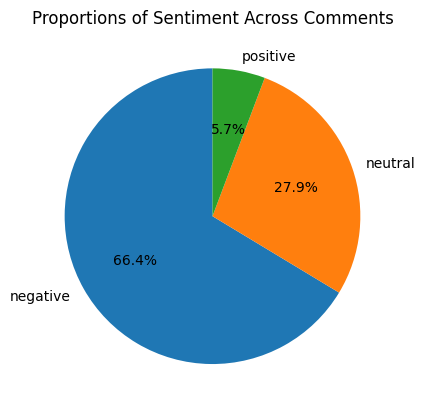

In [ ]:
sentiment_counts = df['sentiment_model2'].value_counts()

labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportions of Sentiment Across Comments')

Overall sentiment surrounding the Israel-Palestine conflict tends to lean toward negative with 66.4% of the data being identified as negative. This can be attributed to the fact that the Israel-Palestine conflict is a highly sensitive topic with ongoing violence which is difficult to make poaitive comments about.

In [ ]:
df = pd.read_csv('final_sentiment (1).csv')

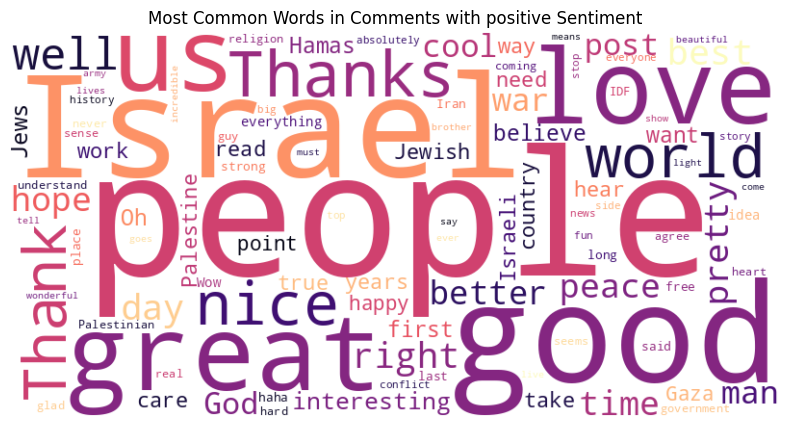

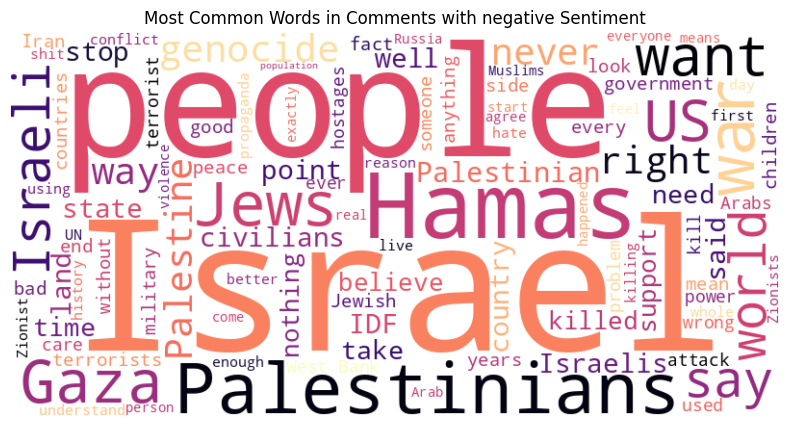

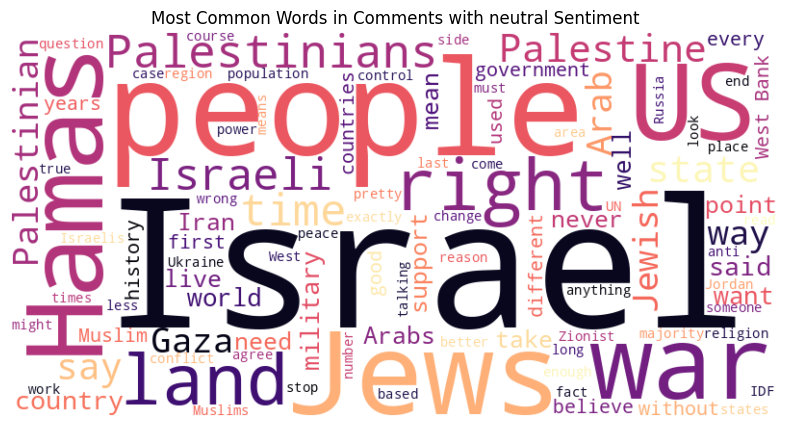

In [ ]:
def generate_sentiment_wordcloud(df, sentiment):
    sentiment_wc = df[df['sentiment_model2'] == sentiment]
    all_tokens = " ".join([" ".join(tokens) for tokens in sentiment_wc['self_text_tokens']])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='magma',
        normalize_plurals=False,
        stopwords=all_stopwords,
        max_words=100
    ).generate(all_tokens)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words in Comments with {sentiment} Sentiment")
    plt.show()

generate_sentiment_wordcloud(df, 'positive')
generate_sentiment_wordcloud(df, 'negative')
generate_sentiment_wordcloud(df, 'neutral')

We can use word clouds to illustrate the general narratives of comments based on its sentiment. In our word cloud of positive comments, it is evident that there is a greater occurrence of lighthearted and optimistic terms such as "great", "love", "good", and "peace". In our word cloud of negative comments, there are much more sensitive terms associated with conflict such as "war", "killed", "attack", and "genocide". Lastly, in our word cloud of neutral comments, there exists a larger quantity of general informative language such as "Israel", "US", "Hamas", and "government". This helps us understand te general conversations that are relevant to each sentiment category.

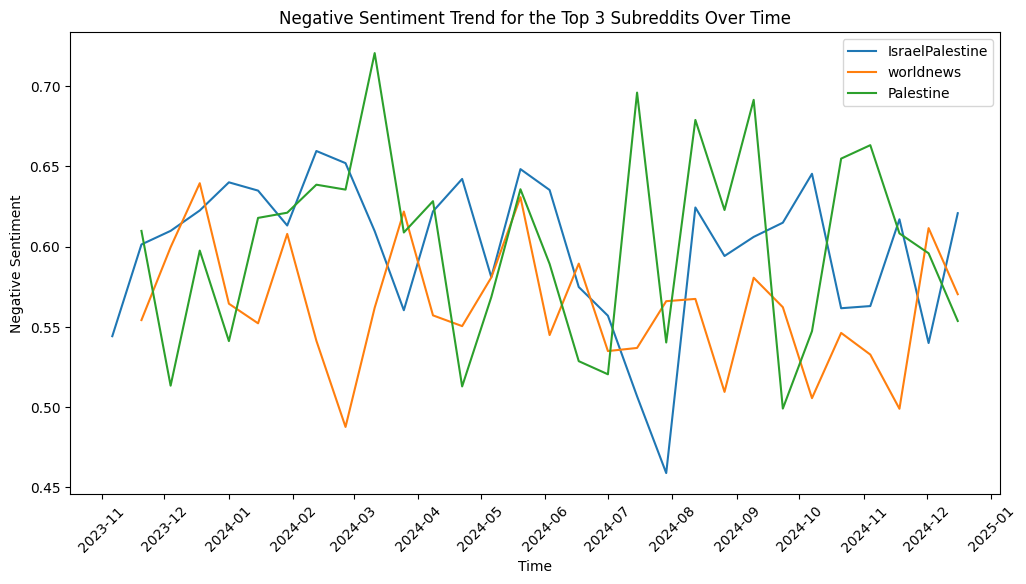

In [ ]:
top_subreddits = ['IsraelPalestine', 'worldnews', 'Palestine']
filtered_df = df[df['subreddit'].isin(top_subreddits)]

filtered_df.loc[:, 'created_time'] = pd.to_datetime(filtered_df['created_time'])
weekly_sentiment = filtered_df.groupby([pd.Grouper(key='timestamp', freq='2W-MON'), 'subreddit'])['negative'].mean().reset_index()

sentiment_pivot = weekly_sentiment.pivot(index='timestamp', columns='subreddit', values='negative')

fig, ax = plt.subplots(figsize=(12, 6))
for subreddit in top_subreddits:
    ax.plot(sentiment_pivot.index, sentiment_pivot[subreddit], label=subreddit)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Negative Sentiment')
ax.set_title('Negative Sentiment Trend for the Top 3 Subreddits Over Time')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()

As mentioned previously, we can use a time series visualization to best depict trends in our data. Such trends can help determine associations with global events and predict future trends.

In this time series visualization, we can see the negative sentiment trend for the top 3 subreddits over time. One thing to note is that throughout the entire time frame of this dataset, the subreddits “Palestine” and “IsraelPalestine” appear to have opposing trends with the subreddit “worldnews” in negative sentiment. This may indicate that, on average, the subreddits also had opposing views throughout the recorded time frame. We can identify a spike in negative sentiment near September 2024, which may be associated with the involvement of Lebanon and Iran in the Israel-Palestine War. Overall, the “worldnews” subreddit had less negative sentiment than the other two subreddits.

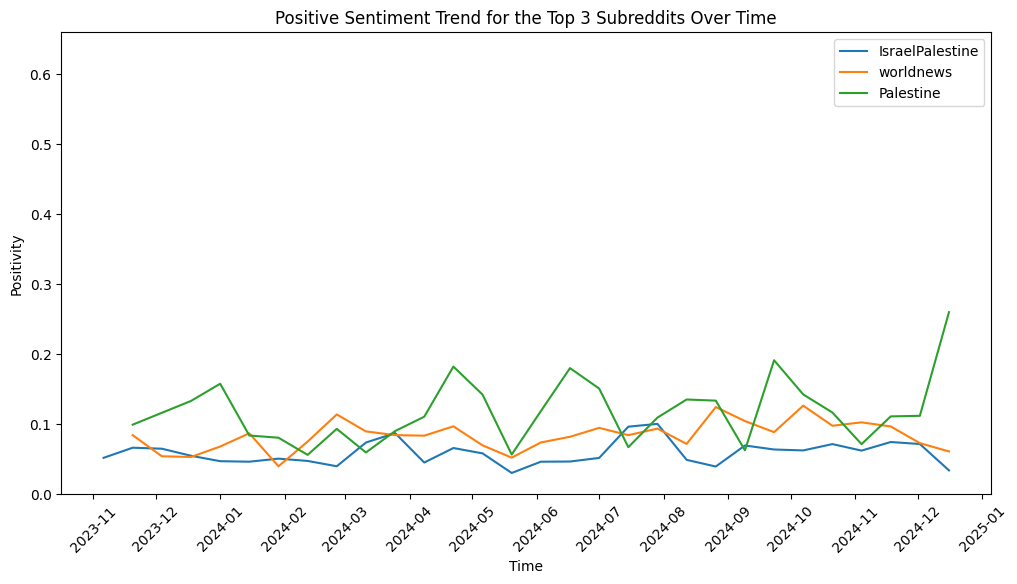

In [ ]:
weekly_sentiment = filtered_df.groupby([pd.Grouper(key='created_time', freq='2W-MON'), 'subreddit'])['positive'].mean().reset_index()
sentiment_pivot = weekly_sentiment.pivot(index='created_time', columns='subreddit', values='positive')
fig, ax = plt.subplots(figsize=(12, 6))

for subreddit in top_subreddits:
    ax.plot(sentiment_pivot.index, sentiment_pivot[subreddit], label=subreddit)

ax.set_ylim(0, 0.66) # Setting the y-axis similarly to the negative plot for comparison

ax.set_xlabel('Time')
ax.set_ylabel('Negative Sentiment')
ax.set_title('Positive Sentiment Trend for the Top 3 Subreddits Over Time')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

warnings.filterwarnings("ignore")

In this time series visualization, we can see the positive sentiment trend for the top 3 subreddits over time. As we saw in the pie chart, the positive sentiment score of comments is overall much lower than the negative sentiment scores in the previous graph. Additionally, like the previous visualization, we can identify opposing trends in positive sentiment between the subreddits “Palestine” and “IsraelPalestine”. Another intriguing factor of this visualization is that the “worldnews” subreddit has the tendency to be in between the data of the other subreddits. This may indicate less bias as the subreddit likely does not show much positive sentiment towards either side. Thus, we can infer that the “worldnews” subreddit may have a more neutral stance amongst the top subreddits.

All in all, our implementation of sentiment analysis provided deeper context to the public discourse surrounding this war. From our visualizations, we can conclude that the majority of such public discourse is negative, with varying spikes and drops indicating reactions to global events. We can also claim that differing trends in sentiment exist across the subreddits, which may help determine the nuances in neutrality and bias.

## **b. K Means Clustering**

K Means Clustering is a unsupervised learning technique that groups similar data points together. Since it is unsupervised, it does not need the data to have pre-exisiting labels. We are using it in our project to help group our tokens into different clusters so that we can find the main topics that are being discussed about the conflict on Reddit.

In [ ]:
df = pd.read_csv('final.csv')

In [ ]:
print("Original TF-IDF Shape:", tfidf_matrix.shape)

svd = TruncatedSVD(n_components=2, random_state=42)
data_2d = svd.fit_transform(tfidf_matrix)
print("Reduced TF-IDF Shape:", data_2d.shape)


scaler = StandardScaler()
scaled_tfidf_matrix = scaler.fit_transform(data_2d)

Here we reduced the dimensionality of our TF-IDF array from 19470 down to 2. This is because K Means Clustering does not do well with high dimensions so this is the first thing we need to do before continuing on.

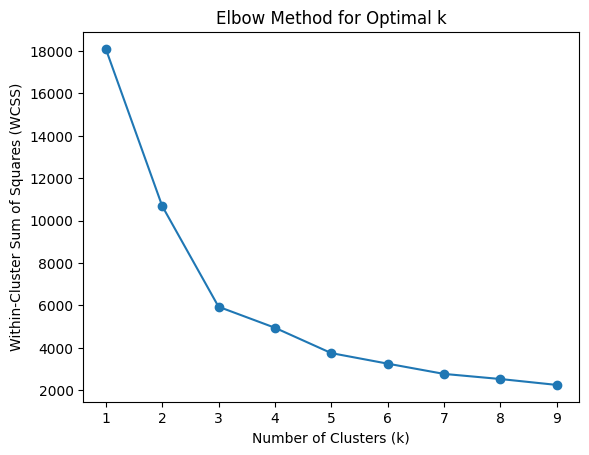

In [ ]:
cluster_range = range(1, 10)

wcss = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(scaled_tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data_2d)

df['cluster'] = kmeans.labels_

silhouette_avg = silhouette_score(data_2d, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.44630443026032773


We utilized two different methods for helping choose our k value for k means clustering. First we created a graph that visualizes the WCSS values for the different number of clusters. In this graph we can see there is an inflection point at k = 3 and a much smaller one at k = 5. Then we checked the silhouette score for both and ended up getting a higher score on k = 3. However, even though k = 5 has a lower silhouette score, we were able to find more insightful topics that were discussed with 5 clusters instead of 3 so we chose k = 5.   

<ipython-input-28-1350ff2978fd>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df['cluster'], cmap=plt.cm.get_cmap('viridis', len(df['cluster'].unique())))


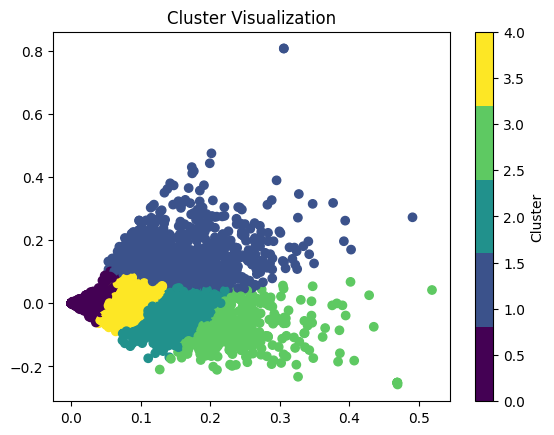

In [ ]:
df['cluster'] = df['cluster'].astype('category')
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=df['cluster'], cmap=plt.cm.get_cmap('viridis', len(df['cluster'].unique())))
plt.title("Cluster Visualization")
plt.colorbar(scatter, label='Cluster')
plt.show()

Since we reduced our dimensions down to 2, we can create a visualization like this that displays like a map for our clusters. Each unique color is a different cluster and we can see some clusters are well defined and packed in while other clusters are more loose and contain outliers in our data. The more loose clusters could represent more nuanced discussions with multiple sub-topics or it could show the cluster's topic is not as well defined.

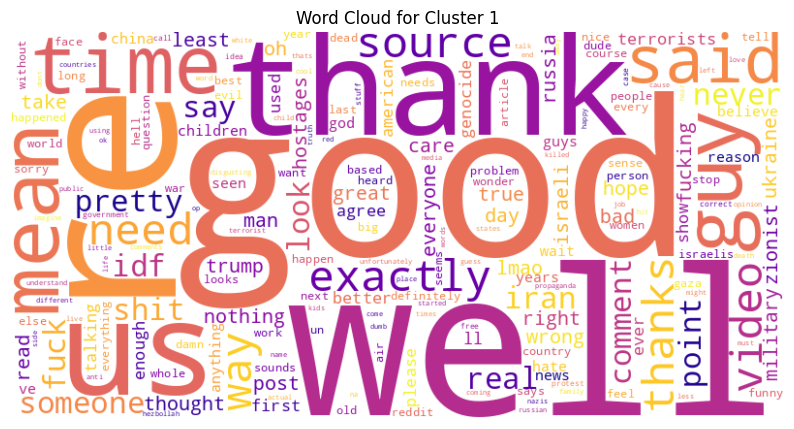

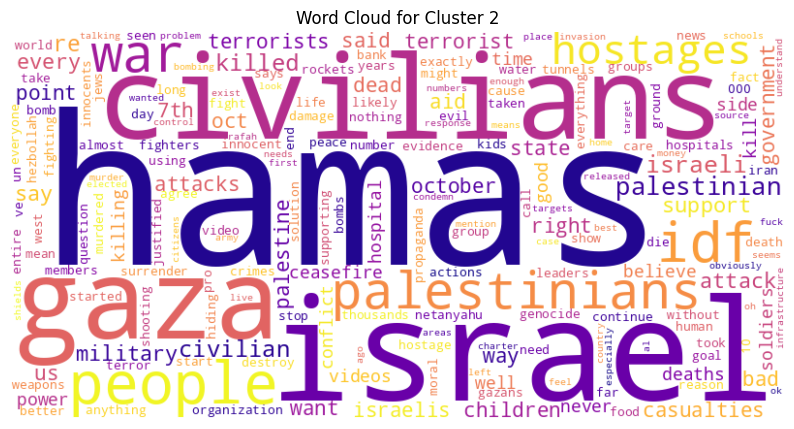

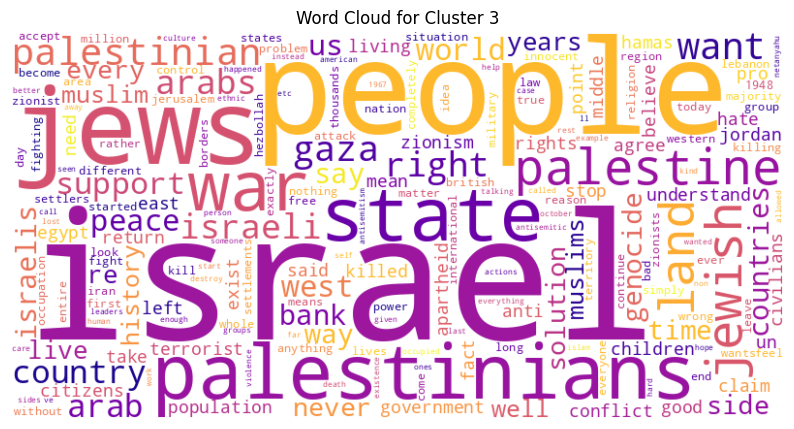

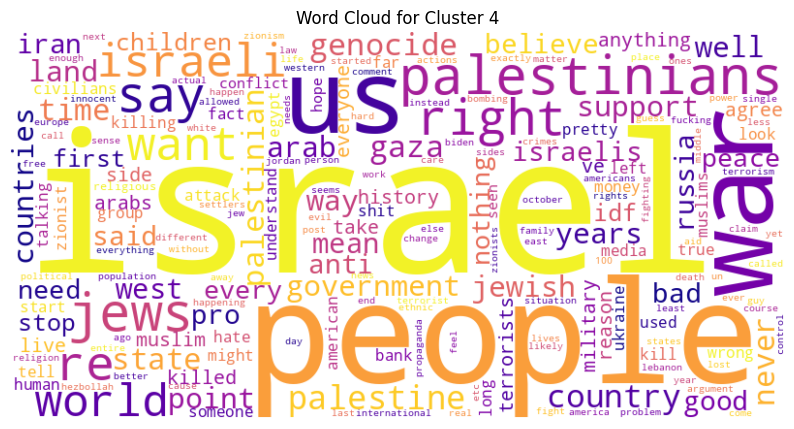

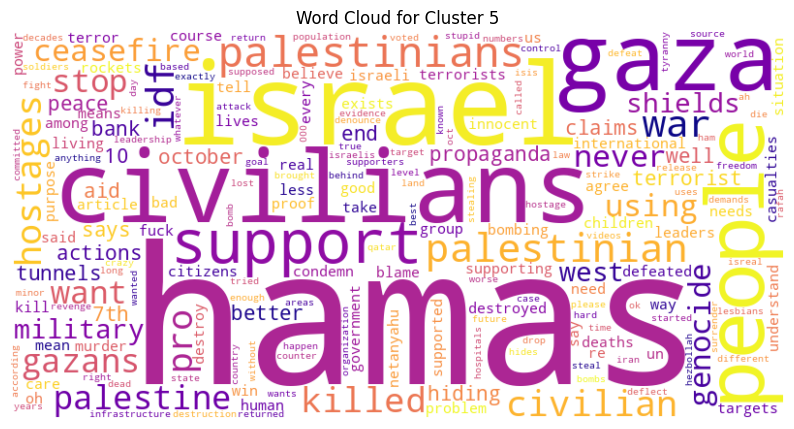

In [ ]:
for cluster_num in range(kmeans.n_clusters):
    cluster_docs = tfidf_matrix[df['cluster'] == cluster_num]
    mean_tfidf = cluster_docs.mean(axis=0).A1

    term_weights = dict(zip(terms, mean_tfidf))
    term_weights_lower = {k.lower(): v for k, v in term_weights.items()}

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma',
      stopwords=all_stopwords).generate_from_frequencies(term_weights_lower)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_num + 1}")
    plt.show()


In [ ]:
cluster_terms = {}
for i in range(kmeans.n_clusters):
    cluster_terms[i] = tfidf_matrix[df['cluster'] == i]

for cluster_num in range(kmeans.n_clusters):
    print(f"\nCluster {cluster_num + 1} Top Terms:")

    cluster_docs = tfidf_matrix[df['cluster'] == cluster_num]

    mean_tfidf = cluster_docs.mean(axis=0).A1

    terms_df = pd.DataFrame({'term': terms, 'score': mean_tfidf})
    top_terms = terms_df.sort_values(by='score', ascending=False).head(20)

    print(top_terms)



Cluster 1 Top Terms:
          term     score
7219      good  0.005139
17663     well  0.004853
13205       re  0.004576
16190    thank  0.004202
17178       us  0.003944
16360     time  0.003898
7464       guy  0.003861
10217     mean  0.003837
14105     said  0.003822
5985   exactly  0.003816
17346    video  0.003776
16194   thanks  0.003775
15127   source  0.003754
10990     need  0.003681
17596      way  0.003637
12597   pretty  0.003581
8157       idf  0.003566
9823      look  0.003495
8852      iran  0.003435
14200      say  0.003393

Cluster 2 Top Terms:
               term     score
7520          hamas  0.123306
8929         israel  0.044409
3203      civilians  0.028519
7027           gaza  0.026307
11992        people  0.023383
8157            idf  0.020967
17529           war  0.018592
11750  palestinians  0.017775
7983       hostages  0.015515
11748   palestinian  0.015385
8930        israeli  0.014056
3202       civilian  0.013112
9265         killed  0.012666
13205      

With the results of the word clouds and the top 20 TF-IDF terms in each cluster, we can get a better understanding of the overall topic the clusters separated into.

##*Cluster 1:*

This cluster’s top terms have a mix of positive and negative sentiment words, such as "good", "well", "thank", "bad". However, there are mostly neutral general words like "work", "way", "thing". This suggests the cluster is focusing on the general discussions and quick responses people have about the conflict, while also talking about practical implications and effects.



##*Cluster 2:*

Cluster 2 becomes significantly more specific as it is centered around the military conflict, especially in relation to Gaza. Words such as "military", "attack", "rockets", "killed", "children" depict the grim reality of those in the area. We can establish that this cluster is heavily focused on military actions and the impacts they have on the civilians of Gaza.



##*Cluster 3:*

Within cluster 3, we see a more political, historical, and ideological discussion of the conflict. "Zionism", "antisemitism", "jewish", and "peace", help show historical motivations as well as global implications of the war. Overall, the cluster tries to focus in on the complex nature of the Israel-Palestine issue


##*Cluster 4:*

This cluster seems to focus on the discussion of the United States and its role in respect to the conflict. Words like "us", "country", "american", "government", "support", "world", "side" suggest public opinion debating on the US involvement along with other countries in the world. This cluster may relate to the strong alliance between the United States and Israel.



##*Cluster 5:*

For the last cluster, the topic is centered around support for the Hamas and Palestinian side while talking about the cruelty of Israeli policies. This is seen with words such as "Hamas", "terrorist", "innocent", "ceasefire", "pro", "right", "stop". It is evident that this cluster deals with controversial opinions in regards to the war while showing public opinion in favor of Hamas and Palestine.



There are many nuanced topics about the Israel-Palestine conflict that can be seen with these different clusters. Even though we can see certain tokens repeated across different clusters, the topic surrounding each token varies depending on the context of the cluster, as seen through the TF-IDF analysis. For example, "Israel" is discussed in context of Hamas and the Palestinians for one cluster, Jewish identity and statehood in another, while also in context of US involvement and the morality of the war. By examining these clusters, we gain a deeper understanding of the different layers of the Israel-Palestine conflict as reflected in public discourse. Such diverse layers highlight the complexity of the topic and the narratives that exist within ongoing conversations.

##**c. N-Grams**

N-Grams is a technique used for text analysis that groups the tokens in our dataset into N sized groups. For example if N is 2, then it would group the tokens into pairs. With the tokens grouped this way, we can find the most frequent N-Grams to provide more context on the public opinion than just looking at one token at a time. Here we will be using Bigrams and Trigrams, which will be looking at pairs and triplets.

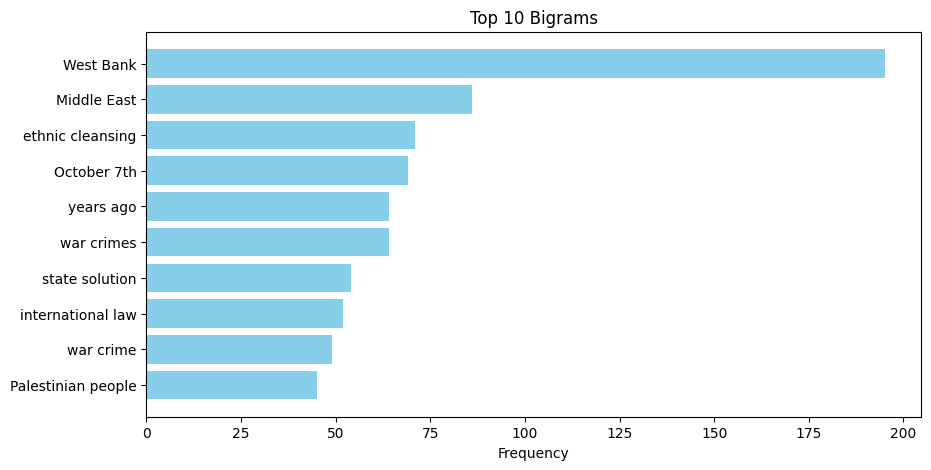

In [ ]:
from nltk.util import ngrams
from collections import Counter

def generate_ngrams(text_list, n):
    filtered_text_list = [word for word in text_list if len(word) > 2]
    return list(ngrams(filtered_text_list, n))

all_bigrams = []
all_trigrams = []

for tokens in df['self_text_tokens']:
    all_bigrams.extend(generate_ngrams(tokens, 2))
    all_trigrams.extend(generate_ngrams(tokens, 3))

bigram_counts = Counter(all_bigrams)

top_bigrams = bigram_counts.most_common(10)

plt.figure(figsize=(10, 5))
plt.barh([f"{w1} {w2}" for w1, w2 in dict(top_bigrams).keys()], dict(top_bigrams).values(), color='skyblue')
plt.xlabel("Frequency")
plt.title("Top 10 Bigrams")
plt.gca().invert_yaxis()
plt.show()

This is the result of our Bigrams analysis. The top bigrams seem to just be about the geographical location of the conflict. "Ethnic cleansing" is related to what people think the conflict is stemming from which is still widely debated on. "October 7th" is the date of the major event where Hamas attacked Isreal. "State solution" shows the discussion on a possible solution to the conflict of having Israelis and Palestinians have their own independent state. Lastly for "palestinian people", it shows the discussion is mostly in the perspective of Palestinians.

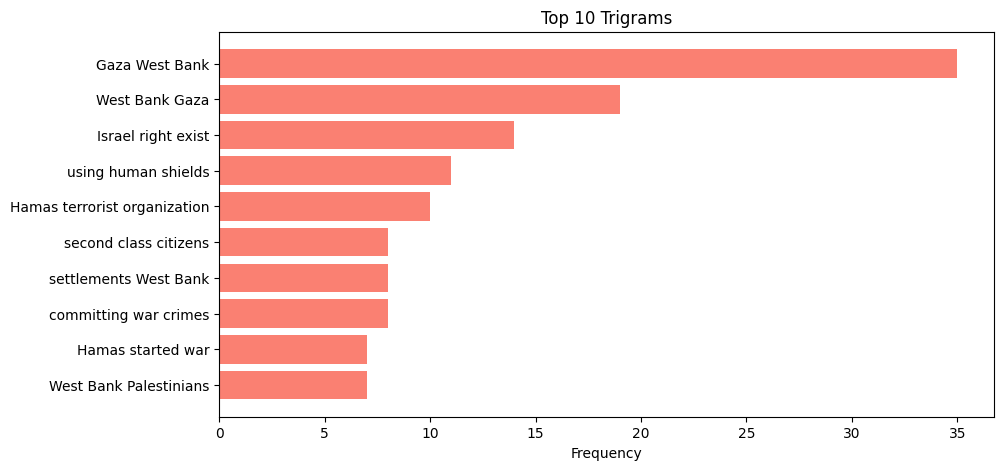

In [ ]:
trigram_counts = Counter(all_trigrams)

top_trigrams = trigram_counts.most_common(10)

plt.figure(figsize=(10, 5))
plt.barh([f"{w1} {w2} {w3}" for w1, w2, w3 in dict(top_trigrams).keys()], dict(top_trigrams).values(), color='salmon')
plt.xlabel("Frequency")
plt.title("Top 10 Trigrams")
plt.gca().invert_yaxis()
plt.show()

For this N-Grams graph, we increased the size to be trigrams. The most frequent trigrams are again just about the geography of the conflict. "Israel right exist" is a bit ambigious but we can assume it means Israelis have the right to exist. This could signify public opinion backing Israel. Other trigrams such as "Hamas terrorist organization", "using human shields", "Hamas started war" also lean towards that idea as well. "Second class citizens" relates towards how Palestinians are treated like second class citizens which sparks discussions about how Palestinians are being discriminated against and not given the same rights. Overall, the top trigrams shown in the graph portray that their is support and discussion for both sides of the conflict. With the bigrams there can be seen a lean in support towards the Palestinians while for trigrams there can be seen a lean in support towards the Israeli side.

# Conclusion


With a comprehensive analysis of this data, we can gain a deeper understanding of the various elements of the Israel-Palestine War as presented in public discourse. This study holds great significance considering the war is an ongoing conflict with geopolitical, social, and humanitarian implications. As displayed in a number of our visualizations, the top two leading terms of this study are “Israel” and “Hamas”. Therefore, it can be inferred that the public views the conflict as more of a war between Israel and Hamas rather than between Israel and Palestine. This suggests the idea that people perceive Hamas as the leading representative of all Palestinian people.

Demonstrated by assorted time series visualizations, we can associate certain trends and changes in our data with major events relevant to the Israel-Palestine War. We can associate significant changes in occurrence of controversiality with significant geopolitical events. For example, the assassination of Hamas leader, Yahya Sinwar (October 2024), is consistent with spikes in controversiality, while the involvement of Lebanon and Iran led to spikes in negative sentiment. Adding on, the sentiment analysis of individual subreddits established that there exists subreddits with less bias and more neutrality than others. Overall, the majority of the dataset was identified as “negative”, which can be established to be in accordance with the sensitive nature of the topic.

In addition, the topics discovered in the K-Means Clustering showed that some of the main topics were in support of Hamas and Palestine along with international support for them as well. Many of the most frequent bigrams also display support for Palestinians and discuss possible solutions to the conflict. In comparison, the trigrams present more advocacy for Israel and criticize the actions of Hamas.

Our analysis is currently constrained mainly by the dataset size (lack of access to stronger processing units) and limitations of sentiment models; however, a vision we have for our project's next step could be predicting responses to real-world events. Specifically, we hope to train our own machine learning model to identify hate speech or misleading content early on to improve current measures set in place to remove/prevent such content.


#Contribution:
Risa Onishi: Sentiment analysis implementation and all corresponding visualizations. Assisted in data cleaning/tokenization. Report organization and finalization. Final presentation video editing.

Ashna Pradhan: Created and analyzed word cloud and time series in the EDA. Conducted TF-IDF calculations on all tokens. Provided analysis of geopolitical events.

Sazen Shakya: Implemented K Means Clustering with word cloud and scatter plot visualizations. Conducted N-Grams analysis on bigrams and trigrams and created respective bar graph to display.

Haru Sakamoto: Worked on the text processing, including data cleaning and tokenization. Created bar graphs on the subreddits in the EDA and added descriptions. Assisted with sentiment analysis visualizations.  



|


#Citations:
https://acleddata.com/middle-east/regional-overviews/



|

|

|

|

|

|

|

|
|

|

|

|
|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|

|
